# Test Maximum snow density implemented in CLASSIC snow model

**env: sc2_v0**

The maximum snow density s,max is estimated as a function of snow depth zs, after Tabler et al. (1990):
s,max=As-204.70zs1.0-e-zs0.673
Following Brown et al. (2006), the empirical constant As is assigned a value of 450.0 for cold snowpacks and 700.0 for snowpacks near the melting point:

   if (FI(I) > 0. .and. ZSNOW(I) > 0.0001) then
     if (TSNOW(I) < - 0.01) then
       RHOMAX(I) = 450.0 - (204.7 / ZSNOW(I)) * &
                   (1.0 - EXP( - ZSNOW(I) / 0.673))
     else
       RHOMAX(I) = 700.0 - (204.7 / ZSNOW(I)) * &
                   (1.0 - EXP( - ZSNOW(I) / 0.673))
     end if
   end if



In [25]:
import proplot as pplt
import numpy as np
import matplotlib.pyplot as plt

## Define parameterizations

In [14]:
def BR06_dry(sd):
    """
    Calculates the maximum snow density using the Brown et al. (2006) parameterization for dry snow.
    (https://doi.org/10.3137/ao.440302)

    Parameters:
    sd (float): Snow depth [m]

    Returns:
    rho_max (float): The maximum snow density [kg m$^{-3}$.
    """
    rho_max = 450.0 - (204.7 / sd) * (1.0 - np.exp( - sd / 0.673))
    return rho_max

def BR06_wet(sd):
    """
    Calculates the maximum snow density using the Brown et al. (2006) parameterization for wet snow.
    (https://doi.org/10.3137/ao.440302)

    Parameters:
    sd (float): Snow depth [m]

    Returns:
    rho_max (float): The maximum snow density [kg m$^{-3}$.
    """
    rho_max = 700.0 - (204.7 / sd) * (1.0 - np.exp( - sd / 0.673))
    return rho_max

def TB90(sd):
    """
    Calculates the maximum snow density using the Tabler et al. (1990) parameterization.
    (https://westernsnowconference.org/node/620)

    Parameters:
    sd (float): Snow depth [m]

    Returns:
    rho_max (float): The maximum snow density [kg m$^{-3}$.
    """
    rho_max = 522.0 - (204.7 / sd) * (1.0 - np.exp( - sd / 0.673))
    return rho_max

In [11]:
sd = pplt.arange(0.1, 5, 0.1)
sd

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. ])

In [12]:
BR06_wet(sd)

array([417.35802071, 436.87108579, 454.58795764, 470.6946449 ,
       485.35660953, 498.72113097, 510.9193905 , 522.06830966,
       532.2721722 , 541.62405588, 550.20709666, 558.09560549,
       565.35605535, 572.04795382, 578.22461499, 583.93384249,
       589.21853425, 594.11721811, 598.66452652, 602.89161737,
       606.8265474 , 610.49460345, 613.91859675, 617.11912434,
       620.11480142, 622.9224681 , 625.55737332, 628.0333387 ,
       630.36290447, 632.55745962, 634.627358  , 636.58202195,
       638.43003486, 640.17922395, 641.83673422, 643.40909476,
       644.90227804, 646.32175308, 647.67253316, 648.95921863,
       650.18603534, 651.35686925, 652.47529745, 653.54461621,
       654.56786618, 655.5478551 , 656.48717835, 657.38823748,
       658.25325693, 659.08429917])

## Plot

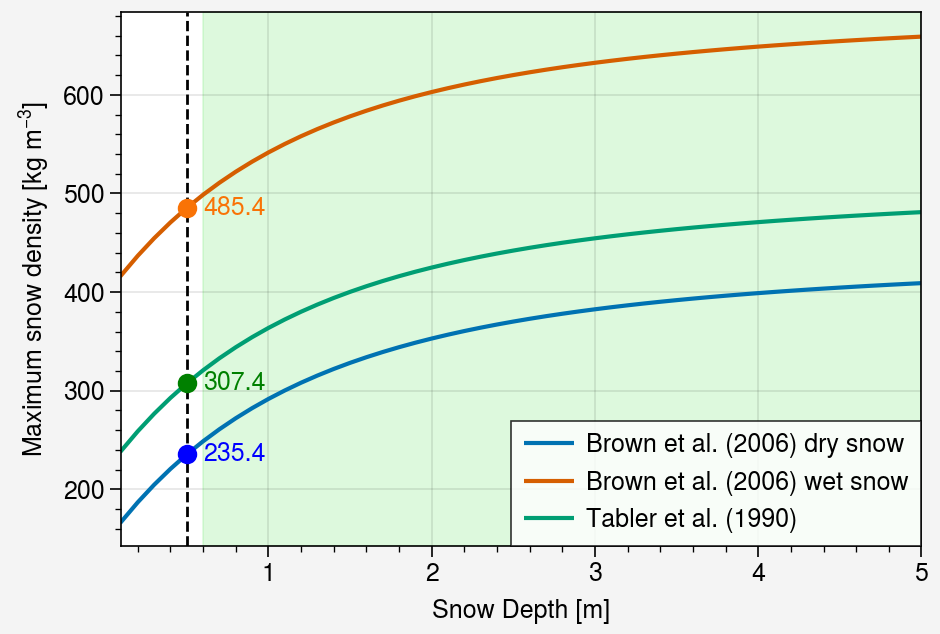

In [37]:
fig, axs = pplt.subplots(refwidth=4, refaspect=1.5)

ax = axs[0]

ax.plot(sd, BR06_dry(sd), label='Brown et al. (2006) dry snow')
ax.plot(sd, BR06_wet(sd), label='Brown et al. (2006) wet snow')
ax.plot(sd, TB90(sd), label='Tabler et al. (1990)')

# Add the shaded rectangle
ax.axvspan(0.6, sd[-1], color='lightgreen', alpha=0.3)

# Add the vertical line at snow depth of 0.5
ax.axvline(0.5, color='black', linestyle='--', lw=1)

# Calculate and annotate the crossing values
dry_crossing = BR06_dry(0.5)
wet_crossing = BR06_wet(0.5)
tb90_crossing = TB90(0.5)

# Plot the intersection points
ax.plot(0.5, dry_crossing, 'o', color='blue')
ax.plot(0.5, wet_crossing, 'o', color='orange')
ax.plot(0.5, tb90_crossing, 'o', color='green')

# Annotate the crossing values
ax.text(0.6, dry_crossing, f'{dry_crossing:.1f}', verticalalignment='center', color='blue')
ax.text(0.6, wet_crossing, f'{wet_crossing:.1f}', verticalalignment='center', color='orange')
ax.text(0.6, tb90_crossing, f'{tb90_crossing:.1f}', verticalalignment='center', color='green')

ax.format(
    xlabel='Snow Depth [m]',
    ylabel='Maximum snow density [kg m$^{-3}$]',
)

ax.legend(ncols=1)
fig.save('img/rho_max_vs_sd.jpg')